<a href="https://colab.research.google.com/github/doorunderground/kiosk/blob/main/trained_age_estimation_data_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# User Code to train a model that can estimate age using a dataset of human faces.

In [ ]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.layers import BatchNormalization, Conv2D, MaxPool2D, Activation, Dropout, Lambda, Dense, Flatten, Input
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from tensorflow.keras import backend as k
from glob import glob
import seaborn as sns
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd /content/drive/MyDrive

/content/drive/MyDrive


In [ ]:
folder_name = 'face12'

In [ ]:
def parse_dataset(dataset_path, ext='jpg'): #jpg파일로 인자받기

    def parse_info_from_file(path):
        try:
            filename = os.path.split(path)[1]  #파일경로에서 파일이름 추출
            filename = os.path.splitext(filename)[0]  # 파일 이름에서 jpg확장자 제거
            age, gender, race, _ = filename.split('_')  #파일이름에서 나이, 성, 인종 구분 후 정보 추출

            return int(age) #나이값만 반환, 나이정보 없으면 None
        except Exception as ex:
            return None

    files = glob(os.path.join(dataset_path, "*.%s" % ext))

    records = []
    for file in files:
        info = parse_info_from_file(file) #파일 경로에서 나이 정보 추출
        records.append(info) #리스트에 나이정보들 추가

    df = pd.DataFrame(records) #리스트를 데이터프레임으로 변환
    df['file'] = files   #files 리스트를 데이터프레임에 추가
    df.columns = ['age', 'file']  #데이터프레임의 열 이름 변경
    df = df.dropna() # 결측값제거거

    return df

In [ ]:
df = parse_dataset(folder_name)

In [ ]:
df.head() #젤앞 5개 확인

,age,file
0,9.0,face12/9_0_0_20170110224607682.jpg.chip.jpg
1,8.0,face12/8_1_0_20170109204910999.jpg.chip.jpg
2,8.0,face12/8_0_0_20170117175637404.jpg.chip.jpg
3,7.0,face12/7_1_0_20170109200933192.jpg.chip.jpg
4,81.0,face12/81_1_2_20170105174804349.jpg.chip.jpg


In [ ]:
import plotly.graph_objects as go

def plot_distribution(pd_series):
    labels = pd_series.value_counts().index.tolist() #각 레이블별 빈도수 구하고 인덱스를 리스트로 변환
    counts = pd_series.value_counts().values.tolist() #각 레이블별 빈도수 구하고 값들을 리스트로 변환

    pie_plot = go.Pie(labels=labels, values=counts, hole=.3)  #파이차트 생성
    fig = go.Figure(data=[pie_plot]) #파이차트를 데이터로 포함하는 객체 생성
    fig.update_layout(title_text='Distribution for %s' % pd_series.name)  #제목

    fig.show()

In [ ]:
bins = [0, 10, 20, 30, 40, 60, 80, np.inf] #나이를 구간으로 나누는 경계값
names = ['<10', '10-20', '20-30', '30-40', '40-60', '60-80', '80+'] # 각구간별 이름
age_binned = pd.cut(df['age'], bins, labels=names) #나이를 구간화 하고, 각구간의 이름 지정
plot_distribution(age_binned)              #데이터셋 나이별 비율

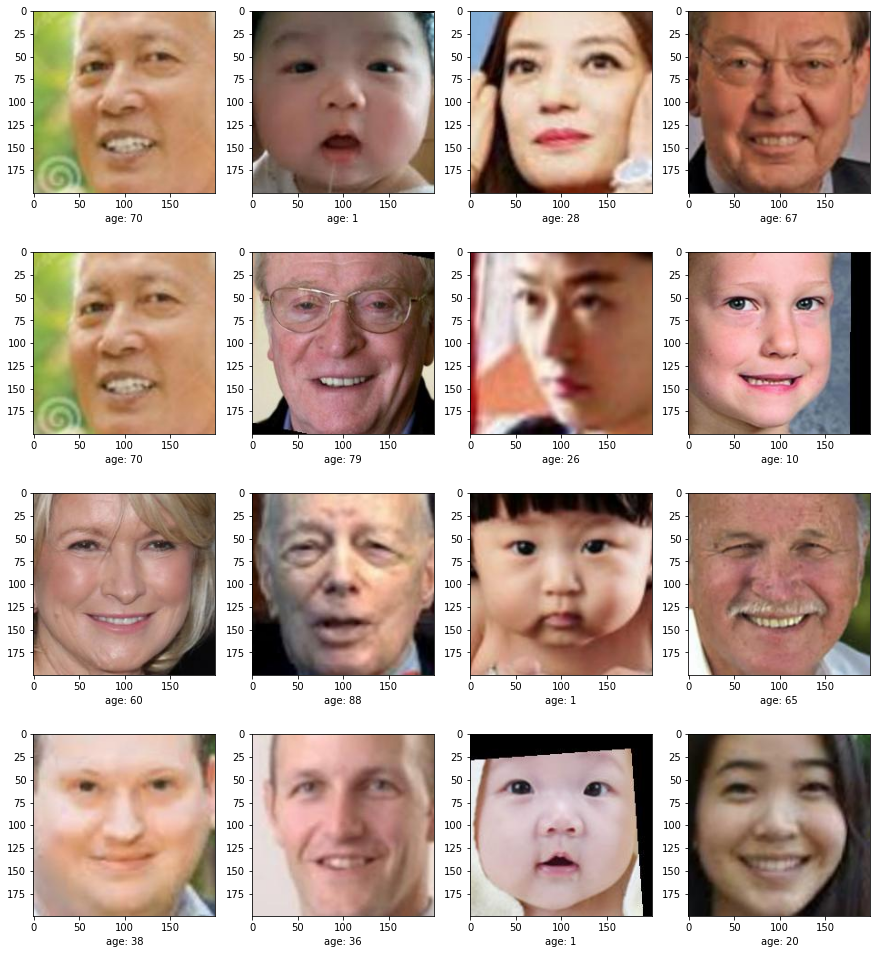

In [ ]:
import math
n=16   #이미지 16개
random_indices = np.random.choice(df.index.tolist(), size=n)   #데이터셋에서 16개 무작위선택
n_cols = 4 # 한행에 열 개수
n_rows = math.ceil(n / n_cols) # 행의 개수
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 17))
for i, x in enumerate(random_indices): #16개 이미지 출력
   ax = axes.flat[i] #i번째 subplot
   img = cv2.imread(df['file'][x]) #이미지 읽어오기
   img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # 이미지 색상 BGR에서 RGB로 변환
   ax.imshow(img)  #이미지 출력
   pic_age = df['age'][x] #연령 추출
   ax.set_xlabel('age: {}'.format(int(pic_age)))


In [ ]:
images = []
age = []
for img in os.listdir(folder_name): #폴더 내 이미지 파일에 대해 반복
  ages = img.split("_")[0] #이미지 파일명에서 연령정보 추출
  img = cv2.imread(str(folder_name)+"/"+str(img))
  img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB) #색상 공간 변환
  img = img
  images.append(np.array(img)) #이미지 데이터를 리스트에 추가
  age.append(np.array(ages)) #연령정보를 리스트에 추가

age = np.array(age,dtype=np.int64)  #학습모델에 넣기위해 numpy 배열로 변환
images = np.array(images)


In [ ]:
x_train_age, x_test_age, y_train_age, y_test_age = train_test_split(images, age, random_state=42, test_size=0.4)   #train이랑 (validation,test)  6:4로나눔
x_valid_age , x_test_age  , y_valid_age, y_test_age = train_test_split(x_test_age, y_test_age, random_state=42, test_size=0.5)  # validation test를 5:5로 나눔

In [ ]:
from tensorflow.keras.optimizers import legacy
init_lr = 1e-4  #초기 학습률
epochs = 100
opt = legacy.Adam(learning_rate=0.0001, decay=1e-6) #에폭이 증가하는동안 학습률 감소시키는 속도: decay

In [ ]:
age_model = Sequential([
    Conv2D(128, kernel_size =3, input_shape=(200,200,3)), #컨볼루션층, 3*3필터, 입력이미지 200*200, RGB채널 3개
    BatchNormalization(), #배치정규화
    Activation('relu'), #활성함수
    MaxPool2D(pool_size=3, strides=2), #맥스풀링, 3*3, stride = 2
    Conv2D(128, kernel_size =3), #2번째 컨볼루션층, 3*3필터
    BatchNormalization(),
    Activation('relu'),
    MaxPool2D(pool_size=3, strides=2),
    Conv2D(256, kernel_size =3),
    BatchNormalization(),
    Activation('relu'),
    MaxPool2D(pool_size=3, strides=2),
    Conv2D(256, kernel_size =3),
    BatchNormalization(),
    Activation('relu'),
    MaxPool2D(pool_size=3, strides=2),
    Conv2D(512, kernel_size =3),
    BatchNormalization(),
    Activation('relu'),
    MaxPool2D(pool_size=3, strides=2),
    Flatten(), #1차원 배열로 변환
    Dropout(0.25), #드롭아웃 25%
    Dense(512, activation  = 'relu'),  #완전연결층
    Dense(1, activation = 'linear', name = 'age')
])
age_model.compile(loss="mse", optimizer=opt, metrics = ['mae'])

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint

In [ ]:
callbacks = [EarlyStopping(monitor='loss', patience=5), ModelCheckpoint(filepath='./model/best_model_{val_loss:.2f}.h5',
                                             monitor='val_loss',
                                             save_best_only=True)]
#조기종료 5번, 손실이 개선될때마다 모델저장,

In [ ]:
history_age = age_model.fit(x_train_age, y_train_age,
                        validation_data=(x_valid_age, y_valid_age), batch_size = 16, epochs=100, callbacks = callbacks)
#x_train_age:학습데이터, y_train_age:학습데이터의 레이블, validation_data:검증데이터와 레이블

Epoch 1/100
507/507 [==============================] - 54s 105ms/step - loss: 255.5995 - mae: 12.0835 - val_loss: 363.9827 - val_mae: 14.7521
Epoch 2/100
507/507 [==============================] - 51s 101ms/step - loss: 142.6023 - mae: 9.0523 - val_loss: 121.8783 - val_mae: 8.0934
Epoch 3/100
507/507 [==============================] - 52s 102ms/step - loss: 112.2589 - mae: 7.9303 - val_loss: 115.7863 - val_mae: 7.8881
Epoch 4/100
507/507 [==============================] - 52s 102ms/step - loss: 90.7598 - mae: 7.1085 - val_loss: 109.4015 - val_mae: 7.5545
Epoch 5/100
507/507 [==============================] - 52s 102ms/step - loss: 77.8016 - mae: 6.6341 - val_loss: 110.5529 - val_mae: 7.5751
Epoch 6/100
507/507 [==============================] - 52s 103ms/step - loss: 67.3700 - mae: 6.1346 - val_loss: 86.4404 - val_mae: 6.7601
Epoch 7/100
507/507 [==============================] - 51s 101ms/step - loss: 57.0419 - mae: 5.6612 - val_loss: 108.7596 - val_mae: 7.5259
Epoch 8/100
507/507 [==

In [ ]:
age_model.save('./model/age_model_rate0.0001.h5')

In [ ]:
history_age

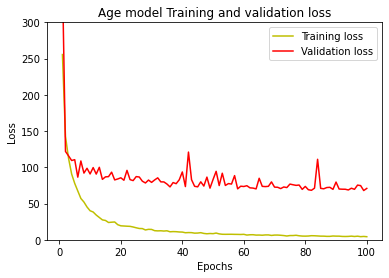

In [ ]:
#학습결과 손실 그래프프
history = history_age
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Age model Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.ylim(0,300)
plt.legend()
plt.show()

In [ ]:
len(x_test_age) #테스트 데이터 개수수

2703

In [ ]:
y_test_age[0] #첫 번째 테스트 데이터의 실제 나이이

31

In [ ]:
age_predict = age_model.predict(x_test_age) #테스트 데이터 예측

85/85 [==============================] - 6s 53ms/step


In [ ]:
from sklearn.metrics import mean_absolute_error, accuracy_score, recall_score, precision_score, confusion_matrix, classification_report

In [ ]:
age_mae = mean_absolute_error(y_test_age, age_predict) #MAE 계산

age_mae

5.706279903755028

In [ ]:
import math
n=16
random_indices = np.random.choice(len(x_test_age), size=n)  #테스트 데이터 중에 랜덤16개개
n_cols = 4
n_rows = math.ceil(n / n_cols)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 17))
for i, x in enumerate(random_indices):
   ax = axes.flat[i]
   ax.imshow(x_test_age[x])
   real_age = y_test_age[x] #실제 나이
   predict_age = age_predict[x] #예측 나이
   ax.set_title('21812152') #제목목
   ax.set_xlabel('real_age: {} , predict_age: {} '.format(int(predict_age), int(real_age)))
   ax.xaxis.label.set_color('red')
